# Grover's Algorithm
Grover's Quantum Search Algorithm is described in this document. Grover's Algorithm leverages certain geometric properties of Hilbert Spaces to perform database searching in $O(\sqrt{N})$ time. We first import the necessary qiskit libraries and define the required number of bits in the input.

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
# Define number of input bits
a = '010x01x'
n = len(a)

## Objective
We are given an oracle function $f(x)$ thats acts on $n$ bit inputs and produces a $0$ or a $1$ as output. The oracle function $f(x)$ is associated with a set of $m$ specific $n$ bit numbers $\{a_1, a_2, \dots a_m\}$. $f(x)$ tells us whether a given input $a$ belongs to this set or not. Thus,

$$f(x) = \begin{cases}
&1\;; \quad x \in \{a_1, a_2, \dots a_m\} \\
&0\;; \quad x \not\in \{a_1, a_2, \dots a_m\} \end{cases}$$

We are not informed of the set $\{a_1, a_2, \dots a_m\}$, but we do know the number of elements in the set. Our objective is to search for an element $a_i \in \{a_1, a_2, \dots a_m\}$ using a minimum number of calls to the oracle.

## Prerequisites
Before describing Grover's Algorithm, we shall need to develop two theorems that we will have the need to invoke, while describing the circuit operation. This is done in the following. We also define the Grover Operators $V$ and $W$ in the context of the second of these theorems. The second theorem is essentially the core idea behind Grover's Algorithm.

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to $|0\rangle_n$. We claim that

$$H^{\otimes n}|0\rangle_n = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$

#### Proof
$$\begin{align*}
H^{\otimes n}|0\rangle_n &= H|0\rangle \otimes H|0\rangle \otimes \cdots \otimes H|0\rangle \\
&= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + |1\rangle\right) \otimes \left(|0\rangle + |1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + |1\rangle\right) \right)
\end{align*}$$

Now, multiplying out the $\left(|0\rangle + |1\rangle\right)$ terms, we get a sum of all possible combinations of zeroes and ones. Thus, we get our final result,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

### Theorem 2
Define the states $|\phi\rangle$ and $|\psi\rangle$ as

$$|\phi\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \qquad |\psi\rangle = \frac{1}{\sqrt{m}} \sum_{i = 1}^m |a_i\rangle_n$$

Define the Grover Operators $V$ and $W$ as

$$V = I - 2|\psi\rangle\langle\psi| \qquad W = 2|\phi\rangle\langle\phi| - I$$

Let $|\chi\rangle$ be any state in the plane of $|\phi\rangle$ and $|\psi\rangle$, i.e., in the 2D subspace spanned by $|\phi\rangle$ and $|\psi\rangle$. Let $|\psi_\perp\rangle$ be the vector orthogonal to $|\psi\rangle$ in the same plane and let $\theta$ be the angle between $|\phi\rangle$ and $|\psi_\perp\rangle$, i.e., $\theta = cos^{-1} \left(|\langle\psi_\perp|\phi\rangle|\right)$.

Then, we claim that the action of the operator $VW$ rotates the state $|\chi\rangle$ by $2\theta$ towards $|\psi\rangle$.

#### Proof
The above claim is easily visualized geometrically. First, let $S = span\{|\phi\rangle, |\psi\rangle\}$. Note that $\langle\phi|\psi\rangle = \langle\psi|\phi\rangle = \sqrt{\frac{m}{2^n}}$. We observe that

$$\begin{align}
V|\phi\rangle = |\phi\rangle - 2\sqrt{\frac{m}{2^n}}|\psi\rangle \qquad &V|\psi\rangle = -|\psi\rangle \\
W|\phi\rangle = |\phi\rangle \qquad &W|\psi\rangle = 2\sqrt{\frac{m}{2^n}}|\phi\rangle - |\psi\rangle \\
\end{align}$$

Thus, $|\chi\rangle \in S \implies VW|\chi\rangle \in S$. Notice that $V$ preserves the component of $|\chi\rangle$ along $|\psi_\perp\rangle$ while it negates the component of $|\chi\rangle$ along $|\psi\rangle$. Thus, $V$ is a reflection about $|\psi_\perp\rangle$. Similarly, $W$ can be seen as a reflection about $|\phi\rangle$. Two relections make a rotation on the plane. Thus, $VW$ is a rotation.

Let $|\chi\rangle$ make an angle $\gamma$ with $|\psi_\perp\rangle$. We know $|\phi\rangle$ makes an angle $\theta$ with $|\psi_\perp\rangle$. Since $V$ is a reflection about $|\psi_\perp\rangle$, therefore $V|\chi\rangle$ makes an angle $-\gamma$ with $|\psi_\perp\rangle$ and hence an angle $-\theta - \gamma$ with $|\phi\rangle$. Reflecting about $|\phi\rangle$, $WV|\chi\rangle$ makes an angle $\theta + \gamma$ with $|\phi\rangle$ and hence an angle $\gamma + 2\theta$ with $|\psi_\perp\rangle$. Thus, $VW$ is a rotation of $2\theta$ toward $|\psi\rangle$.

## Circuit Description & Analysis
Next, we describe the circuit for a single iteration of Grover's Algorithm.

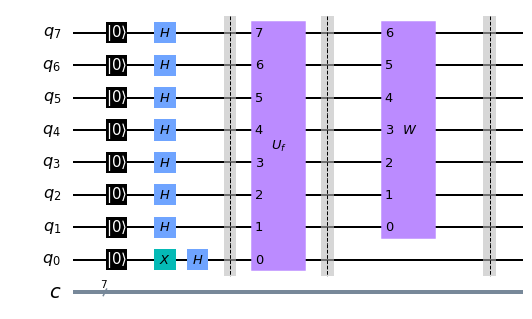

In [3]:
circ = QuantumCircuit(n+1, n)
circ.reset(range(n+1))
circ.x(0)
circ.h(range(n+1))
circ.barrier()
circ.append(Gate(name="$U_f$", num_qubits=n+1, params=[]), range(n+1))
circ.barrier()
circ.append(Gate(name="$\;W\;$", num_qubits=n, params=[]), range(1,n+1))
circ.barrier()
circ.draw('mpl', reverse_bits=True, scale=0.5)

Here, the action of the $(n+1)$ qubit unitary operator $U_f$ is given by

$$U_f|xy\rangle = |x\rangle \otimes |y \oplus f(x)\rangle$$

where $x$ is an $n$ bit number and $y$ is a single bit. In the above circuit, we have marked out 3 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-3 from left to right.

### Barrier 1
We initialize all input qubits to zeros and the output qubit to one. We then apply an $H$ transform to each of the $n+1$ qubits. By theorem 1 above, the state of the qubits is

$$\begin{align*}
|\psi_1\rangle &= H^{\otimes n}|0\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \\
&= |\phi\rangle_n \otimes H |1\rangle
\end{align*}$$

Here, $|\phi\rangle$ is the same state as described in theorem 2 above.

### Barrier 2
We apply the Unitary gate $U_f$ to the qubits. We get

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes \left(\frac{|0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}|x\rangle_n \otimes \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}|x\rangle_n \otimes H|1\rangle
\end{align*}$$

Note that the output qubit remains unchanged since barrier 1. As for the input qubits, $f(x)$ is $1$ only for $x \in \{a_1, a_2, \dots a_m\}$. So, given that the input register was initially in the state $|\phi\rangle$, the component of the input state along $|\psi\rangle$ is flipped in the output. This is the same as the action of the operator $V = I - 2|\psi\rangle\langle\psi|$. Thus, the final state is

$$|\psi_2\rangle = V|\phi\rangle \otimes H|1\rangle$$

### Barrier 3
We apply the operator $W$ as in theorem 2 to the input register. The state becomes

$$|\psi_2\rangle = WV|\phi\rangle \otimes H|1\rangle$$

Thus, the state of the input register, which was initially $|\phi\rangle$ in barrier 1, has now been rotated by $2\theta$ toward $|\psi\rangle$

### Further Iterations
We apply the operators $V$ and $W$ multiple times as in the above steps. Each time the state rotates by $2\theta$ toward $|\psi\rangle$. Note that

$$\theta = cos^{-1} \left(|\langle\psi_\perp|\phi\rangle|\right) = sin^{-1} \left(|\langle\psi|\phi\rangle|\right) = sin^{-1} \sqrt{\frac{m}{2^n}} $$

which is quite small if $2^n$ is large and $m$ is comparatively small. In that case

$$\theta \approx \sqrt{\frac{m}{2^n}} $$

To rotate $|\phi\rangle$ to $|\psi\rangle$ then, requires the following number of iterations

$$\frac{\frac{\pi}{2}}{2\theta} = \frac{\pi}{4\theta} \approx \frac{\pi}{4}\sqrt{\frac{2^n}{m}} $$

Thus, carrying out the above number of iterations (rounded to nearest integer), we can get our final state to be very close to $|\psi\rangle$. A subsequent measurement of the input register will then give out a value of $a \in \{a_1, a_2, \dots a_m\}$ with very high probability. This number can then be passed through the oracle to verify its integrity.

## Qiskit Implementation
We shall need to implement two components before we perform any simulations.

1. The Oracle Circuit $U_f$
2. The Grover Operator $W$

For the oracle circuit we shall choose a circuit which returns $1$ as the output if and only if the input bits match the variable $a$ defined at the beginning of the document exactly, except at the places marked as 'x'. The circuit for this function is easily constructed as below.

For the $W$ Operator, it is easier to construct $-W$, which does not affect circuit operation since $-1$ is a harmless overall phase. We describe the circuit construction below. Note that for both these circuits, a certain number of ancilla qubits are required

### Oracle circuit - V Operator

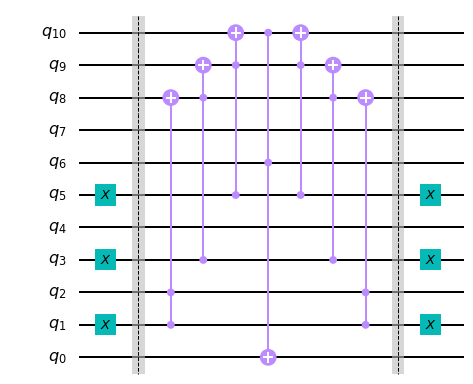

In [4]:
# Initialize quantum circuit
anc = n - a.count('x') - 2
nV = n+1+anc
V = QuantumCircuit(nV, name='f(x)')

# Initialize Toffoli gate list
tof = []
anc = n+1
prevbit = -1

# Acquire gate list
for i in range(n):
    if a[i] == 'x':
        continue
    if prevbit == -1:
        prevbit = i+1
    else:
        tof.append((prevbit, i+1, anc))
        prevbit = anc
        anc += 1

# Set final bit target
tof[-1] = (tof[-1][0], tof[-1][1], 0)

# Build circuit
for i in range(n):
    if a[i] == '0':
        V.x(i+1)
V.barrier()
for i in range(len(tof)):
    V.ccx(tof[i][0], tof[i][1],tof[i][2])
for i in reversed(range(len(tof) - 1)):
    V.ccx(tof[i][0], tof[i][1],tof[i][2])
V.barrier()
for i in range(n):
    if a[i] == '0':
        V.x(i+1)

# Draw Circuit
V.draw('mpl', reverse_bits=True, scale=0.5)

### W Operator
Note that, from theorem 1,

$$-W = I - 2|\phi\rangle\langle\phi| = H^{\otimes n}(I - 2|0 \rangle\langle 0|)H^{\otimes n} = H^{\otimes n}X^{\otimes n}(I - 2|1 \rangle\langle 1|)X^{\otimes n}H^{\otimes n}$$

The Operator $(I - 2|1 \rangle\langle 1|)$ flips the sign of $|11\dots 1\rangle$ and keeps all other states unchanged. Thus,

$$-W = H^{\otimes n}X^{\otimes n}(c^{n-1}Z)X^{\otimes n}H^{\otimes n}$$

This is implemented as follows.

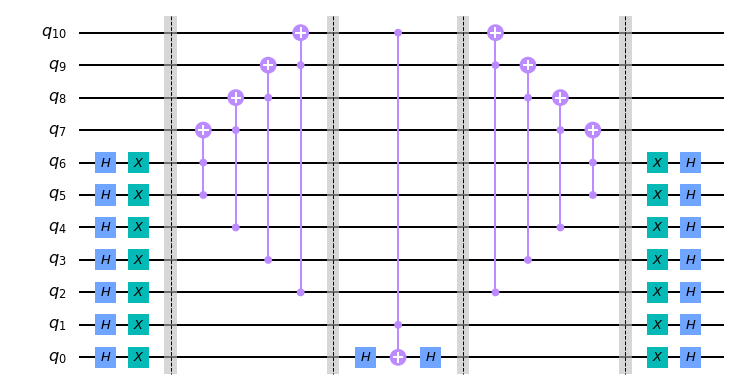

In [5]:
# Initialize quantum circuit
nW = n+n-3
W = QuantumCircuit(nW, name='W')

# Build Circuit
W.h(range(n))
W.x(range(n))
W.barrier()
for i in range(n-3):
    W.ccx(n-2-i, n+i-1, n+i)
W.barrier()
W.h(0)
W.ccx(nW-1, 1, 0)
W.h(0)
W.barrier()
for i in reversed(range(n-3)):
    W.ccx(n-2-i, n+i-1, n+i)
W.barrier()
W.x(range(n))
W.h(range(n))

# Draw circuit
W.draw('mpl', reverse_bits=True, scale = 0.5)

## QASM Simulation

In [6]:
m = 2 ** a.count('x')
N = round((math.pi/4) * math.sqrt((2 ** n) / m))
circ = QuantumCircuit(max(nV, nW+1), n)
circ.reset(range(n+1))
circ.x(0)
circ.h(range(n+1))
circ.barrier()
for i in range(N):
    circ.append(V.to_instruction(), range(nV))
    circ.append(W.to_instruction(), range(1,nW+1))
    circ.barrier()
circ.measure(range(1, n+1), range(n))
circ.draw(reverse_bits=True)

░           ┌─────┐ ░           ┌─────┐ ░           »
q_11: ────────────────░───────────┤10   ├─░───────────┤10   ├─░───────────»
                      ░ ┌────────┐│     │ ░ ┌────────┐│     │ ░ ┌────────┐»
q_10: ────────────────░─┤10      ├┤9    ├─░─┤10      ├┤9    ├─░─┤10      ├»
                      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_9: ────────────────░─┤9       ├┤8    ├─░─┤9       ├┤8    ├─░─┤9       ├»
                      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_8: ────────────────░─┤8       ├┤7    ├─░─┤8       ├┤7    ├─░─┤8       ├»
           ┌───┐      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_7: ─|0>─┤ H ├──────░─┤7       ├┤6    ├─░─┤7       ├┤6    ├─░─┤7       ├»
           ├───┤      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_6: ─|0>─┤ H ├──────░─┤6       ├┤5  W ├─░─┤6       ├┤5  W ├─░─┤6       ├»
           ├───┤      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_5: ─|0>─┤ H ├──────░─┤5  f(x) ├┤4    ├─░─┤5  f(x) ├┤4    ├─░─┤5  f(x) ├»
           ├───┤      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_4: ─|0>─┤ H ├──────░─┤4       ├┤3    ├─░─┤4       ├┤3    ├─░─┤4       ├»
           ├───┤      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_3: ─|0>─┤ H ├──────░─┤3       ├┤2    ├─░─┤3       ├┤2    ├─░─┤3       ├»
           ├───┤      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_2: ─|0>─┤ H ├──────░─┤2       ├┤1    ├─░─┤2       ├┤1    ├─░─┤2       ├»
           ├───┤      ░ │        ││     │ ░ │        ││     │ ░ │        │»
 q_1: ─|0>─┤ H ├──────░─┤1       ├┤0    ├─░─┤1       ├┤0    ├─░─┤1       ├»
           ├───┤┌───┐ ░ │        │└─────┘ ░ │        │└─────┘ ░ │        │»
 q_0: ─|0>─┤ X ├┤ H ├─░─┤0       ├────────░─┤0       ├────────░─┤0       ├»
           └───┘└───┘ ░ └────────┘        ░ └────────┘        ░ └────────┘»
 c_6: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_5: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_4: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_3: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_2: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_1: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_0: ════════════════════════════════════════════════════════════════════»
                                                                          »
«      ┌─────┐ ░           ┌─────┐ ░                      
«q_11: ┤10   ├─░───────────┤10   ├─░──────────────────────
«      │     │ ░ ┌────────┐│     │ ░                      
«q_10: ┤9    ├─░─┤10      ├┤9    ├─░──────────────────────
«      │     │ ░ │        ││     │ ░                      
« q_9: ┤8    ├─░─┤9       ├┤8    ├─░──────────────────────
«      │     │ ░ │        ││     │ ░                      
« q_8: ┤7    ├─░─┤8       ├┤7    ├─░──────────────────────
«      │     │ ░ │        ││     │ ░                   ┌─┐
« q_7: ┤6    ├─░─┤7       ├┤6    ├─░───────────────────┤M├
«      │     │ ░ │        ││     │ ░                ┌─┐└╥┘
« q_6: ┤5  W ├─░─┤6       ├┤5  W ├─░────────────────┤M├─╫─
«      │     │ ░ │        ││     │ ░             ┌─┐└╥┘ ║ 
« q_5: ┤4    ├─░─┤5  f(x) ├┤4    ├─░─────────────┤M├─╫──╫─
«      │     │ ░ │        ││     │ ░          ┌─┐└╥┘ ║  ║ 
« q_4: ┤3    ├─░─┤4       ├┤3    ├─░──────────┤M├─╫──╫──╫─
«      │     │ ░ │        ││     │ ░       ┌─┐└╥┘ ║  ║  ║ 
« q_3: ┤2    ├─░─┤3       ├┤2    ├─░───────┤M├─╫──╫──╫─

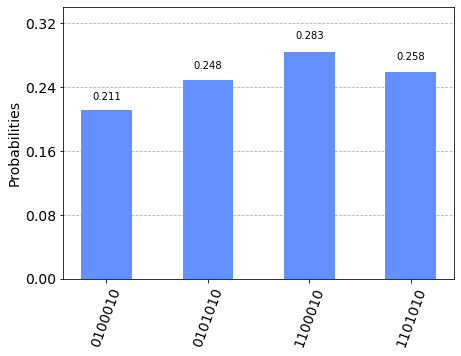

In [7]:
delta = 512
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=delta).result()
counts = result.get_counts(circ)
plot_histogram(counts)

Thus, we see that the desired outcomes are found with very high probability.

## References
1. Grover, L.K., 1997. Quantum mechanics helps in searching for a needle in a haystack. Physical review letters, 79(2), p.325.
2. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
3. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
4. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/